# Question 3 - Price Changes 

## Define Question

Northwind connects buyers and sellers around the world. To better understand the demand of their customers, it is useful to consider regionality. Do customers in some regions have a higher demand for certain products? Demand can be measured by quantity and gross revenue.

> Are there significant differences between demand for various customer regions?

## State Hypothesis

**Null Hypothesis**: There is no difference in demand between customer regions. 

> $H_{o}: \mu_1 = \mu_2 = ... = \mu_n$ 

**Alternative Hypothesis**: There is a statistically significant difference in demand between customer regions. 

> $H_{a}: \mu_1 \neq \mu_i$ 

**Significance Level**: 95% confidence level

> $\alpha = .05$

## Methodology

I load my data and create the desired columns. I test demand by region based on two different criteria: average quantity ordered and average gross revenue.

## Import Libraries and Connect to Data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from hypothesis_testing import bootstrap, create_sampling_distribution, remove_outliers, Cohen_d
import itertools

In [2]:
conn = sqlite3.connect('northwind_small.sqlite')
c = conn.cursor()

## Obtain Data

In [3]:
# Using SQL statements to get a table showing order, order quantity total, and the employee region for each order
customer_query = """SELECT asdf.CustomerID,
                              asdf.OrderQuantity,
                              asdf.OrderID,
                              asdf.GrossRevenue,
                              c.CompanyName,
                              c.Country,
                              c.Region
                              
                    FROM (
                        SELECT o.CustomerId AS CustomerID,
                            o.Id as OrderID,
                            SUM(od.Quantity) AS OrderQuantity,
                            SUM((od.Quantity*od.UnitPrice)*(1-od.Discount)) as GrossRevenue
                            FROM [Order] o
                            INNER JOIN OrderDetail od ON o.Id == od.OrderId
                                
                            GROUP BY o.Id
                            ) asdf
                    JOIN Customer c ON c.Id = asdf.CustomerID
                       
                    """

In [4]:
customer_orders_df = pd.read_sql(customer_query, conn)
customer_orders_df.head()

,CustomerID,OrderQuantity,OrderID,GrossRevenue,CompanyName,Country,Region
0,VINET,27,10248,440.00,Vins et alcools Chevalier,France,Western Europe
1,TOMSP,49,10249,1863.40,Toms Spezialitäten,Germany,Western Europe
2,HANAR,60,10250,1552.60,Hanari Carnes,Brazil,South America
3,VICTE,41,10251,654.06,Victuailles en stock,France,Western Europe
4,SUPRD,105,10252,3597.90,Suprêmes délices,Belgium,Western Europe


## Scrub Data

In [5]:
# Checking sample sizes before regional comparison
customer_orders_df['Region'].value_counts()

Western Europe     272
North America      152
South America      127
British Isles       75
Southern Europe     64
Northern Europe     55
Scandinavia         28
Central America     21
Eastern Europe       7
Name: Region, dtype: int64

In [6]:
customer_orders_df.isna().sum()

CustomerID       0
OrderQuantity    0
OrderID          0
GrossRevenue     0
CompanyName      0
Country          0
Region           0
dtype: int64

## Hypothesis Testing

Performing a Welch's T-Test on samples with less than 30 items can lead to skewed results. Thus Scandinavia, Central America, and Eastern Europe will be excluded from this analysis.

### Order Quantity

First I consider the relationship between region and order quantity.

In [7]:
region_names = np.array(['Western Europe', 'North America', 'South America', 'British Isles', 
                         'Southern Europe', 'Northern Europe'])
region_combinations = itertools.combinations(region_names, 2)

In [8]:
region_combo_df = pd.DataFrame(columns = ['Region 1','Region 2','p-value', 'Reject Null?', 
                                          'Region 1 Quantity Mean', 'Region 2 Quantity Mean', 
                                          'Difference of Means', 'Cohens d'])

In [9]:
for combo in region_combinations:
    
    samp1_control = customer_orders_df[customer_orders_df['Region']==combo[0]]['OrderQuantity']
    samp2_experimental = customer_orders_df[customer_orders_df['Region']==combo[1]]['OrderQuantity']
    
    s1mean = customer_orders_df[customer_orders_df['Region']==combo[0]]['OrderQuantity'].mean()
    s2mean = customer_orders_df[customer_orders_df['Region']==combo[1]]['OrderQuantity'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp1_control, samp2_experimental)
    diff_mean = round(samp1_control.mean() - samp2_experimental.mean(),2)
    effect_size_cohen = round(Cohen_d(samp1_control, samp2_experimental),3)
    
    p_val = p_val / 2 # for one tailed test
    
    region_combo_df = region_combo_df.append({'Region 1' : combo[0], 'Region 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Region 1 Quantity Mean': s1mean, 'Region 2 Quantity Mean': s2mean,
                                                 'Difference of Means': diff_mean, 'Cohens d': effect_size_cohen}, ignore_index=True)

In [10]:
region_combo_df[region_combo_df['Reject Null?'] == "Yes, Reject"]

,Region 1,Region 2,p-value,Reject Null?,Region 1 Quantity Mean,Region 2 Quantity Mean,Difference of Means,Cohens d
1,Western Europe,South America,7.803652e-06,"Yes, Reject",74.341912,50.070866,24.27,0.471
2,Western Europe,British Isles,1.666500e-02,"Yes, Reject",74.341912,59.013333,15.33,0.279
3,Western Europe,Southern Europe,2.220188e-08,"Yes, Reject",74.341912,32.390625,41.95,0.781
5,North America,South America,5.052656e-05,"Yes, Reject",74.434211,50.070866,24.36,0.476
6,North America,British Isles,2.702156e-02,"Yes, Reject",74.434211,59.013333,15.42,0.274
7,North America,Southern Europe,2.989752e-07,"Yes, Reject",74.434211,32.390625,42.04,0.771
9,South America,British Isles,3.943430e-02,"Yes, Reject",50.070866,59.013333,-8.94,0.259
10,South America,Southern Europe,7.645874e-05,"Yes, Reject",50.070866,32.390625,17.68,0.596
11,South America,Northern Europe,1.444356e-02,"Yes, Reject",50.070866,61.909091,-11.84,0.358
12,British Isles,Southern Europe,3.597569e-06,"Yes, Reject",59.013333,32.390625,26.62,0.800


There are several significant results from the combination hypothesis testing. It appears that **Western Europe and North America are performing the strongest** in terms of order quantity. The testing illustrtates a significant difference between both of these regions and most other regions. 

While these are the highest performing regions, the data also reveals some areas which are underperforming. **South America, the British Isles, and Southern Europe all have significantly lower means than their comparisons.** 

Below, I perform the same analysis but for gross revenue instead of quantity.

### Gross Revenue

In [11]:
# T-test for quantity average sales revenue per order from each region
region_names = np.array(['Western Europe', 'North America', 'South America', 'British Isles', 'Southern Europe', 'Northern Europe'])
region_combinations = itertools.combinations(region_names, 2)

region_sales_combo_df = pd.DataFrame(columns = ['Region 1','Region 2','p-value',
                                                      'Reject Null?', 'Region 1 Sales Mean', 'Region 2 Sales Mean',
                                                      'Difference of Means', 'Cohens d'])

for combo in region_combinations:
    
    samp1_control = customer_orders_df[customer_orders_df['Region']==combo[0]]['GrossRevenue']
    samp2_experimental = customer_orders_df[customer_orders_df['Region']==combo[1]]['GrossRevenue']
    
    s1mean = customer_orders_df[customer_orders_df['Region']==combo[0]]['GrossRevenue'].mean()
    s2mean = customer_orders_df[customer_orders_df['Region']==combo[1]]['GrossRevenue'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp1_control, samp2_experimental)
    diff_mean = round(samp1_control.mean() - samp2_experimental.mean(),2)
    effect_size_cohen = round(Cohen_d(samp1_control, samp2_experimental),3)
    
    p_val = p_val / 2 # for one tailed test
    
    region_sales_combo_df = region_sales_combo_df.append({'Region 1' : combo[0], 'Region 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Region 1 Sales Mean': s1mean, 'Region 2 Sales Mean': s2mean,
                                                 'Difference of Means': diff_mean, 'Cohens d': effect_size_cohen}, ignore_index=True)

In [12]:
region_sales_combo_df[region_sales_combo_df['Reject Null?'] == "Yes, Reject"]

,Region 1,Region 2,p-value,Reject Null?,Region 1 Sales Mean,Region 2 Sales Mean,Difference of Means,Cohens d
1,Western Europe,South America,0.000207,"Yes, Reject",1851.280914,1123.447307,727.83,0.384
3,Western Europe,Southern Europe,0.000008,"Yes, Reject",1851.280914,706.651836,1144.63,0.611
5,North America,South America,0.000226,"Yes, Reject",1945.926977,1123.447307,822.48,0.428
6,North America,British Isles,0.043560,"Yes, Reject",1945.926977,1452.682867,493.24,0.244
7,North America,Southern Europe,0.000009,"Yes, Reject",1945.926977,706.651836,1239.28,0.656
10,South America,Southern Europe,0.019748,"Yes, Reject",1123.447307,706.651836,416.80,0.320
11,South America,Northern Europe,0.036844,"Yes, Reject",1123.447307,1584.657500,-461.21,0.292
12,British Isles,Southern Europe,0.000438,"Yes, Reject",1452.682867,706.651836,746.03,0.583
14,Southern Europe,Northern Europe,0.000172,"Yes, Reject",706.651836,1584.657500,-878.01,0.684


Similar to the quantity analysis, these results also indicate that Western Europe and North America are outperforming South America, Southern Europe. Furthermore, North America is also outperforming the British Isles by a significant margin. 

Text(0, 0.5, 'Order Revenue')

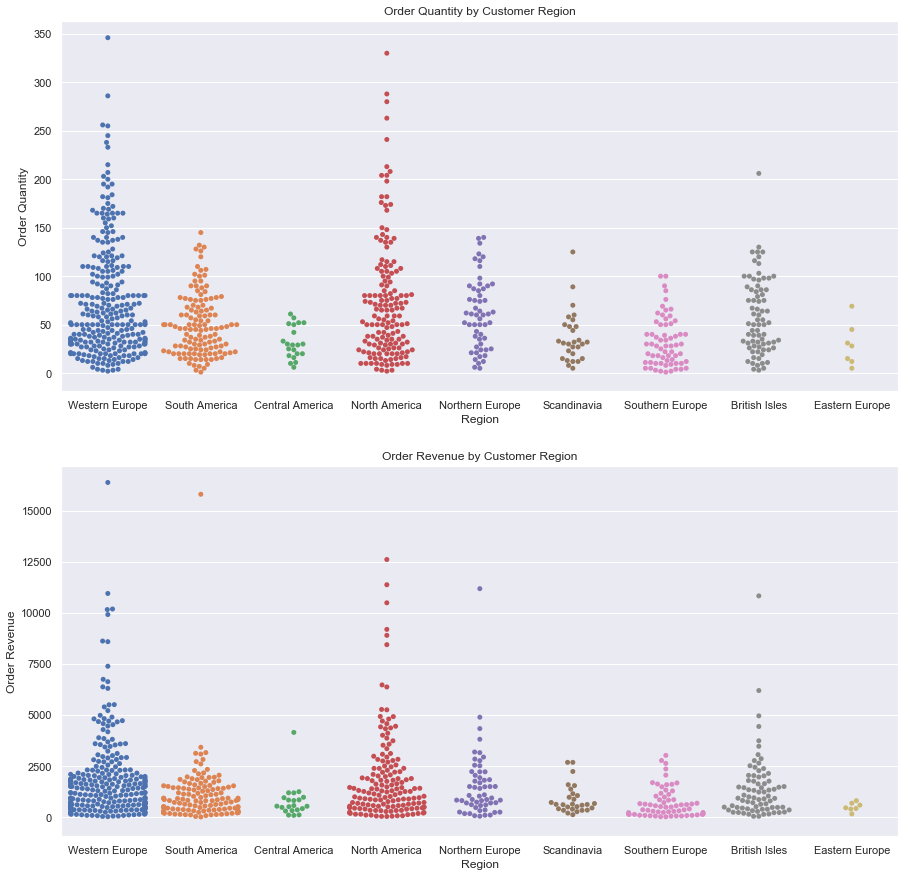

In [31]:
fig, axes = plt.subplots(2,1, figsize=[15,15])

sns.swarmplot(x='Region', y='OrderQuantity', data=customer_orders_df, ax=axes[0])
axes[0].set_title('Order Quantity by Customer Region')
axes[0].set_ylabel('Order Quantity')

sns.swarmplot(x='Region', y='GrossRevenue', data=customer_orders_df, ax=axes[1])
axes[1].set_title('Order Revenue by Customer Region')
axes[1].set_ylabel('Order Revenue')

## Results

When comparing the regions, I determined that the largest and most profitable orders come from North America and Western Europe. I also found that orders in Southern Europe, Northern Europe, and the British Isles are typically smaller. These results held for both quantity ordered and gross revenue.

## Recommendations

Northwinds should prioritize building more rapport with customers in Southern and Northern Europe. I would recommend hiring a product manager who has experience in those regions to help boost sales there.

## Future Work